# Датасет [WIDER FACES](http://shuoyang1213.me/WIDERFACE/)


In [1]:
from scipy import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [130]:
path_mat = 'WiderFaces/wider_face_train.mat'
path_images = 'C:/Users/Fedor/Documents/Projects/BelkaFaces/WiredFaces/WIDER_train/All'

In [131]:
mat = io.loadmat(path_mat)

### Список всех файлов

In [198]:
all_files = mat['file_list']

### Список всех координат лиц

In [5]:
all_boxes = mat['face_bbx_list']

## Пример изображений в датасете

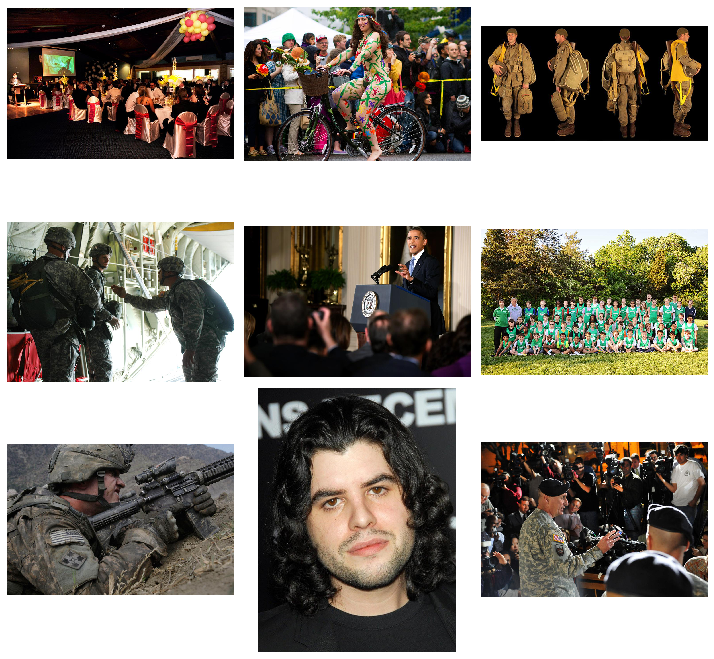

In [334]:
display_images(choose_random_images())

## Получим данные об изображениях в датасете

### Выберем рандомное изображение

In [325]:
random_image = choose_random_images(n=1)[0]
random_image

'40_Gymnastics_Gymnastics_40_578.jpg'

### Его номер в датасете 

In [326]:
folder, file = get_num_of_image(random_image)

Folder: 35 
File: 60


### Координаты лиц на изображении

In [327]:
boxes = get_boxes(folder, file)
boxes

array([[ 55, 214,  39,  38],
       [140, 251,  35,  40],
       [228, 274,  36,  40],
       [257, 237,  35,  38],
       [241, 192,  36,  42],
       [325, 278,  36,  42],
       [349, 222,  36,  38],
       [422, 281,  38,  43],
       [450, 232,  38,  45],
       [569, 221,  48,  48],
       [538, 285,  38,  48],
       [646, 290,  40,  45],
       [753, 153,  41,  48],
       [697, 222,  39,  49],
       [864, 166,  46,  54],
       [762, 297,  38,  43],
       [885, 310,  40,  48]])

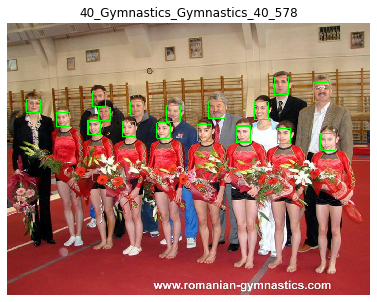

In [328]:
draw_rect(random_image, boxes)

## Easy (Scale) WIDER FACES

Датасет делится на три уровня сложности по размеру лиц на изображении: Легкий (больше 300 pixels), Средний (50-300 pixels), Сложный (10-50 pixels). Мы будем рассматривать легкую часть датасета (по рамзеру лиц), т.к. нам больше важен аспект расположения лица (угол, наклон) и аспект occlusion (макияж, маски, очки и т.д.). К тому же нет необходимости обнаруживать совсем маленькие лица на изображениях. 

In [201]:
easy_names = ['Gymnastics', 'Handshaking', 'Waiter', 'Conference',
                'Worker', 'Parachutist', 'Coach', 'Meeting',
                'Aerobics', 'Boat', 'Dancing', 'Swimming', 
                'Family', 'Balloonist', 'Dresses', 'Couple', 
                'Jockey', 'Tennis', 'Spa', 'Surgeons']


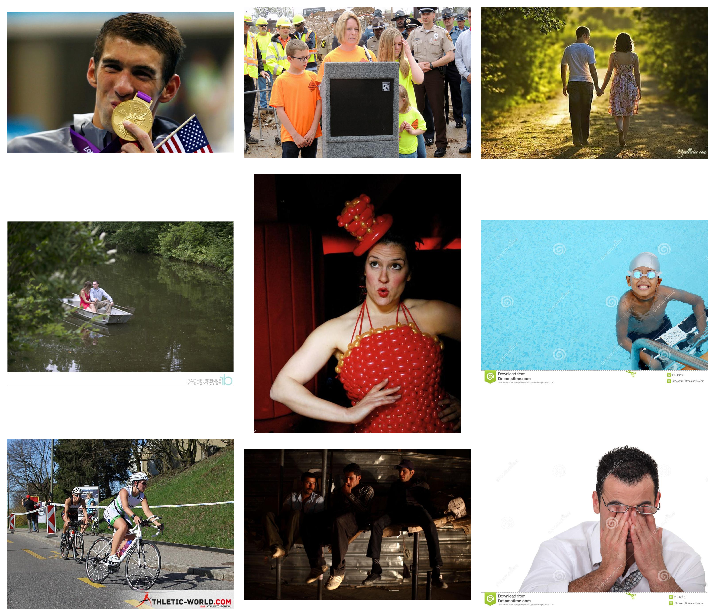

In [217]:
display_images(choose_random_images(easy=True))

## Helpers


In [6]:
def convert2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [210]:
def choose_random_images(easy=False, n=10):
    
    """
    Выбрать из датасета n картинок в случайном порядке
    easy=True -- выбрать из легкой части датасета  
    """
    
    images = []
    for _ in range(n):
        if(easy):
            easy_folders = get_easy_folders()
            folder = all_files[random.choice(easy_folders)]
        else:    
            folder = random.choice(all_files)
            
        name = random.choice(folder[0])[0][0]
        images.append(name + ".jpg")
    return images

In [8]:
def get_num_of_image(name):
    folder_num = -1 
    file_num = -1
    for folder in all_files:
        folder_num += 1
        file_num = -1
        for file_name in folder[0]:
            file_num += 1
            name_ = file_name[0][0]
            if (name_ + '.jpg' == name):
                # print("Folder: {0} \nFile: {1}".format(folder_num, file_num))
                return folder_num, file_num    

In [9]:
def get_boxes(folder, file):
    return all_boxes[folder][0][file][0]

In [10]:
def get_all_boxes(images):
    boxes = []
    for image in images:
        folder, file = get_num_of_image(image)
        boxes.append(get_boxes(folder, file))
    return boxes

In [12]:
def draw_rect(image, boxes):
    test_image = cv2.imread(path_images + '//' + image)
    img_copy = np.copy(test_image)
    
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_copy,(x, y), (x+w, y+h), (0, 255, 0), 2)
        
    fig,ax = plt.subplots(1)
    fig.set_size_inches(9, 5)
    ax.set_title(image.split('.')[0])
    ax.imshow(convert2RGB(img_copy))
    plt.axis('off')
    plt.show()

In [13]:
def display_images(images):
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        test_image = cv2.imread(path_images + '//' + images[i])
        img_copy = np.copy(test_image)
        
        fig.add_subplot(rows, columns, i)
        plt.imshow(convert2RGB(img_copy))
        plt.axis('off')
        plt.tight_layout(True)
    plt.show()
    

In [205]:
def get_easy_folders(easy_names=easy_names):
    easy_folders = []
    for name in easy_names:
        for i in range(0, len(all_files)):
            if (name in all_files[i][0][0][0][0]):
                easy_folders.append(i)
    return easy_folders

# Тестирование решений

**Как будем тестировать?** 

1. Выбираем рандомные n изображений из датасета
2. Получаем координаты всех лиц на всех изображениях 
3. Получаем результаты работы методов на этих изображениях, т.е. получаем координаты лиц
4. Сравниваем полученные результаты с реальными координатами 
5. Считаем среднюю ошибку по координатам. Сортируем методы по возрастанию ошибки
   1. Если метод не дал координат лица (не обнаружил лицо), то добавляем n-m нулевых векторов, где n - количество лиц на изображении, m - количество обнаруженных лиц.

### N рандомных изображений

In [34]:
images = choose_random_images(n=10)

### Координаты лиц

In [35]:
boxes = get_all_boxes(images)

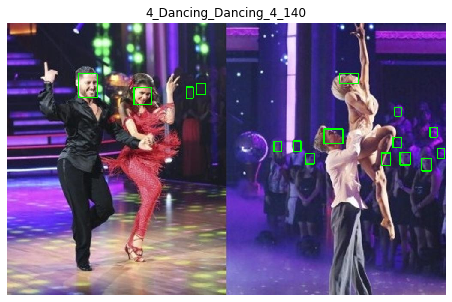

In [82]:
r = random.choice(range(0,10))
draw_rect(images[r], boxes[r])

### Сравнение координат лиц
Для каждого обнаруженного лица в каждой картинке строим евклидову норму (сравнивая с реальными координатами). Итеррируясь по картинкам, считаем ошибку работы текущего метода. 

In [52]:
def mean_error(results, boxes=boxes):
    
    error = 0
    
    # results -- массив массивов координат лиц
    for i in range(0, len(boxes)):
        
        # Кол-во лиц на i картинке
        num_faces = len(boxes[i])
        
        # Дополняем нулевыми векторами,
        # Если лиц обнаружено меньше
        while(len(results[i]) < num_faces):
            results[i] = np.append(results[i], np.zeros(4)) 
        
        for j in range(0, num_faces):
            # Реальные координаты j лица на i картинке
            a = boxes[i][j]
            
            # Координаты j лица на i картинке из метода
            b = results[i][j]
        
            # Евклидова метрика (насколько близки вектора)
            dist = np.linalg.norm(a-b)  
            
            # Ошибка
            error += dist
            
    return error

## Каскады Хаара и LBP ([OpenCV](https://github.com/opencv/opencv))

### Каскады Хаара

In [53]:
haar_path = 'HaarCascades/'
haars = [haar_path + x for x in os.listdir(haar_path)]
haars

['HaarCascades/haarcascade_frontalface_alt.xml',
 'HaarCascades/haarcascade_frontalface_alt2.xml',
 'HaarCascades/haarcascade_frontalface_alt_tree.xml',
 'HaarCascades/haarcascade_frontalface_default.xml',
 'HaarCascades/haarcascade_profileface.xml']

#### Ошибки разных каскадов Хаара

In [62]:
haar_res = cascades_error(haars)
haar_res

{'haarcascade_frontalface_alt': 83670.480366524,
 'haarcascade_frontalface_alt2': 82415.1597169285,
 'haarcascade_frontalface_alt_tree': 84497.89102916184,
 'haarcascade_frontalface_default': 84547.36209052327,
 'haarcascade_profileface': 86603.136550533}

#### Лучший результат

In [63]:
get_best_res(haar_res)

('haarcascade_frontalface_alt2', 82415.1597169285)

### Каскады LBP

In [64]:
lbp_path = 'LBPCascades/'
lbps = [lbp_path + x for x in os.listdir(lbp_path)]
lbps

['LBPCascades/lbpcascade_frontalface.xml',
 'LBPCascades/lbpcascade_frontalface_improved.xml',
 'LBPCascades/lbpcascade_profileface.xml']

#### Ошибки разных LBP каскадов

In [65]:
lbp_res = cascades_error(lbps)
lbp_res

{'lbpcascade_frontalface': 82430.10584162008,
 'lbpcascade_frontalface_improved': 81804.50065725234,
 'lbpcascade_profileface': 84698.44974371875}

#### Лучший результат

In [66]:
get_best_res(lbp_res)

('lbpcascade_frontalface_improved', 81804.50065725234)

### Helpers

In [67]:
def cascades_faces(cascade_path, colored_img, scaleFactor=1.1):
    
    cascade = cv2.CascadeClassifier(cascade_path)
    img_copy = np.copy(colored_img)
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    faces = cascade.detectMultiScale(
        gray, scaleFactor=scaleFactor, minNeighbors=5)

    return faces

In [69]:
def cascades_error(cascades, images=images):
    errors = {}
    for cascade in cascades:
        results_cascade = []
        for image in images:
            faces = cascades_faces(cascade, cv2.imread(path_images + '/' + image))
            results_cascade.append(faces)
        error = mean_error(results_cascade)
        name = cascade.split('/')[1].split('.')[0]
        errors[name] = error

    return errors

In [70]:
def get_best_res(d):
    sorted_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
    return list(sorted_d.items())[0]

## [FaceNet’s MTCNN](https://github.com/davidsandberg/facenet/tree/master/src/align)

In [71]:
from mtcnn import MTCNN 

In [ ]:
def mtcnn_error(iamges=images):
    

In [79]:
def detect_faces(img):
    detector = MTCNN()
    image = cv2.imread(path_images + '/' + images[1])
    faces = detector.detect_faces(image)
    
    return faces 

In [80]:
detect_faces(images[0])

[{'box': [496, 213, 154, 180],
  'confidence': 0.8520547747612,
  'keypoints': {'left_eye': (550, 270),
   'right_eye': (618, 271),
   'nose': (583, 312),
   'mouth_left': (553, 343),
   'mouth_right': (612, 345)}}]

## [dlib's HOG](http://dlib.net/)

## [dlib's MMOD](http://dlib.net/)